In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import re

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Plotting functions

In [3]:
def plot_regression(df, gpu=None, color='black'):
    
    if gpu :
        df = df[df['gpu'] == gpu]
    
    x_range = np.array([
        df['parameters_count'].min(),
        df['parameters_count'].max()
    ]).reshape(-1, 1)

    x = df['parameters_count']
    y = df['energy_per_token']

    poly = PolynomialFeatures(degree=1)
    X = np.array(x).reshape(-1, 1)
    poly.fit(X)
    X_poly = poly.transform(X)
    x_range_poly = poly.transform(x_range)
    model = LinearRegression(fit_intercept=True)
    model.fit(X_poly, y)
    y_poly = model.predict(x_range_poly)
            
    if gpu:
        print(f'Coefs for {gpu}: {model.coef_}')
    else:
        print(f'Coefs for all GPUs: {model.coef_}')
    
    fig.add_trace(go.Scatter(
        x=x_range.squeeze(),
        y=y_poly,
        mode='lines',
        name=f'Linear Regression for {gpu if gpu else "all"} GPUs',
        line=dict(color=color, width=3, dash='dash')
    ))    

In [4]:
def plot_scatter(df, gpu, color):
    
    df = df[df['gpu'] == gpu]

    x = df['parameters_count']
    y = df['energy_per_token']    
    
    fig.add_trace(go.Scatter(
        x=x, 
        y=y,
        mode='markers',
        name=f'Models using {gpu} GPU',
        opacity=0.7,
        marker=dict(color=color)
    ))

# Ml.energy dataset inspection

In [5]:
ml_energy_df = pd.read_csv('./data/aggregated_ml_energy.csv')

In [6]:
ml_energy_df.head()

,model,throughput,response_length,latency,energy,gpu,task,parameters_count,energy_per_token
0,BAIR/koala-13b,25.501170,258.854265,10.063551,1946.198744,A100,chat-concise,13,0.002088
1,BAIR/koala-7b,32.927217,247.045668,7.462044,1195.704790,A100,chat-concise,7,0.001344
2,RWKV/rwkv-raven-7b,64.478527,209.478845,2.921289,736.655330,A100,chat-concise,7,0.000977
3,FreedomIntelligence/phoenix-inst-chat-7b,54.276457,233.511081,4.103907,1002.328573,A100,chat-concise,7,0.001192
4,camel-ai/CAMEL-13B-Combined-Data,26.300221,282.480188,10.727640,2349.183088,A100,chat-concise,13,0.002310


In [7]:
ml_energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             260 non-null    object 
 1   throughput        260 non-null    float64
 2   response_length   260 non-null    float64
 3   latency           260 non-null    float64
 4   energy            260 non-null    float64
 5   gpu               260 non-null    object 
 6   task              260 non-null    object 
 7   parameters_count  260 non-null    int64  
 8   energy_per_token  260 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 18.4+ KB


In [8]:
ml_energy_df.describe()

,throughput,response_length,latency,energy,parameters_count,energy_per_token
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,27.608889,224.494313,8.987958,1759.911630,9.030769,0.002202
std,9.312289,71.271262,4.427355,925.369666,3.079233,0.000936
min,14.438333,60.651444,1.986240,335.256588,3.000000,0.000675
25%,21.429872,181.464322,5.534973,1103.811052,7.000000,0.001444
50%,26.743612,242.940060,8.510843,1571.847936,7.000000,0.002130
75%,31.829087,273.593267,11.585607,2217.752910,13.000000,0.002577
max,66.070161,428.193418,24.003582,4466.796723,13.000000,0.004626


In [9]:
ml_energy_gpus = ml_energy_df['gpu'].unique()

In [10]:
ml_energy_gpus

array(['A100', 'A40', 'V100'], dtype=object)

Il existe 3 types de GPUs dans ce dataset, l'A100, le V100 et l'A40. L'A100 et l'A40 sont basés sur l'architecture Ampère , alors que la V100 est basée sur l'architecture Volta, plus ancienne. L'A40 est plus adaptée au computer vision qu'aux LLM, ce qui pourrait expliquer une conso plus importante.

# Correlation study

In [11]:
num_feat = [col for col in ml_energy_df if ml_energy_df.dtypes[col] != 'object']

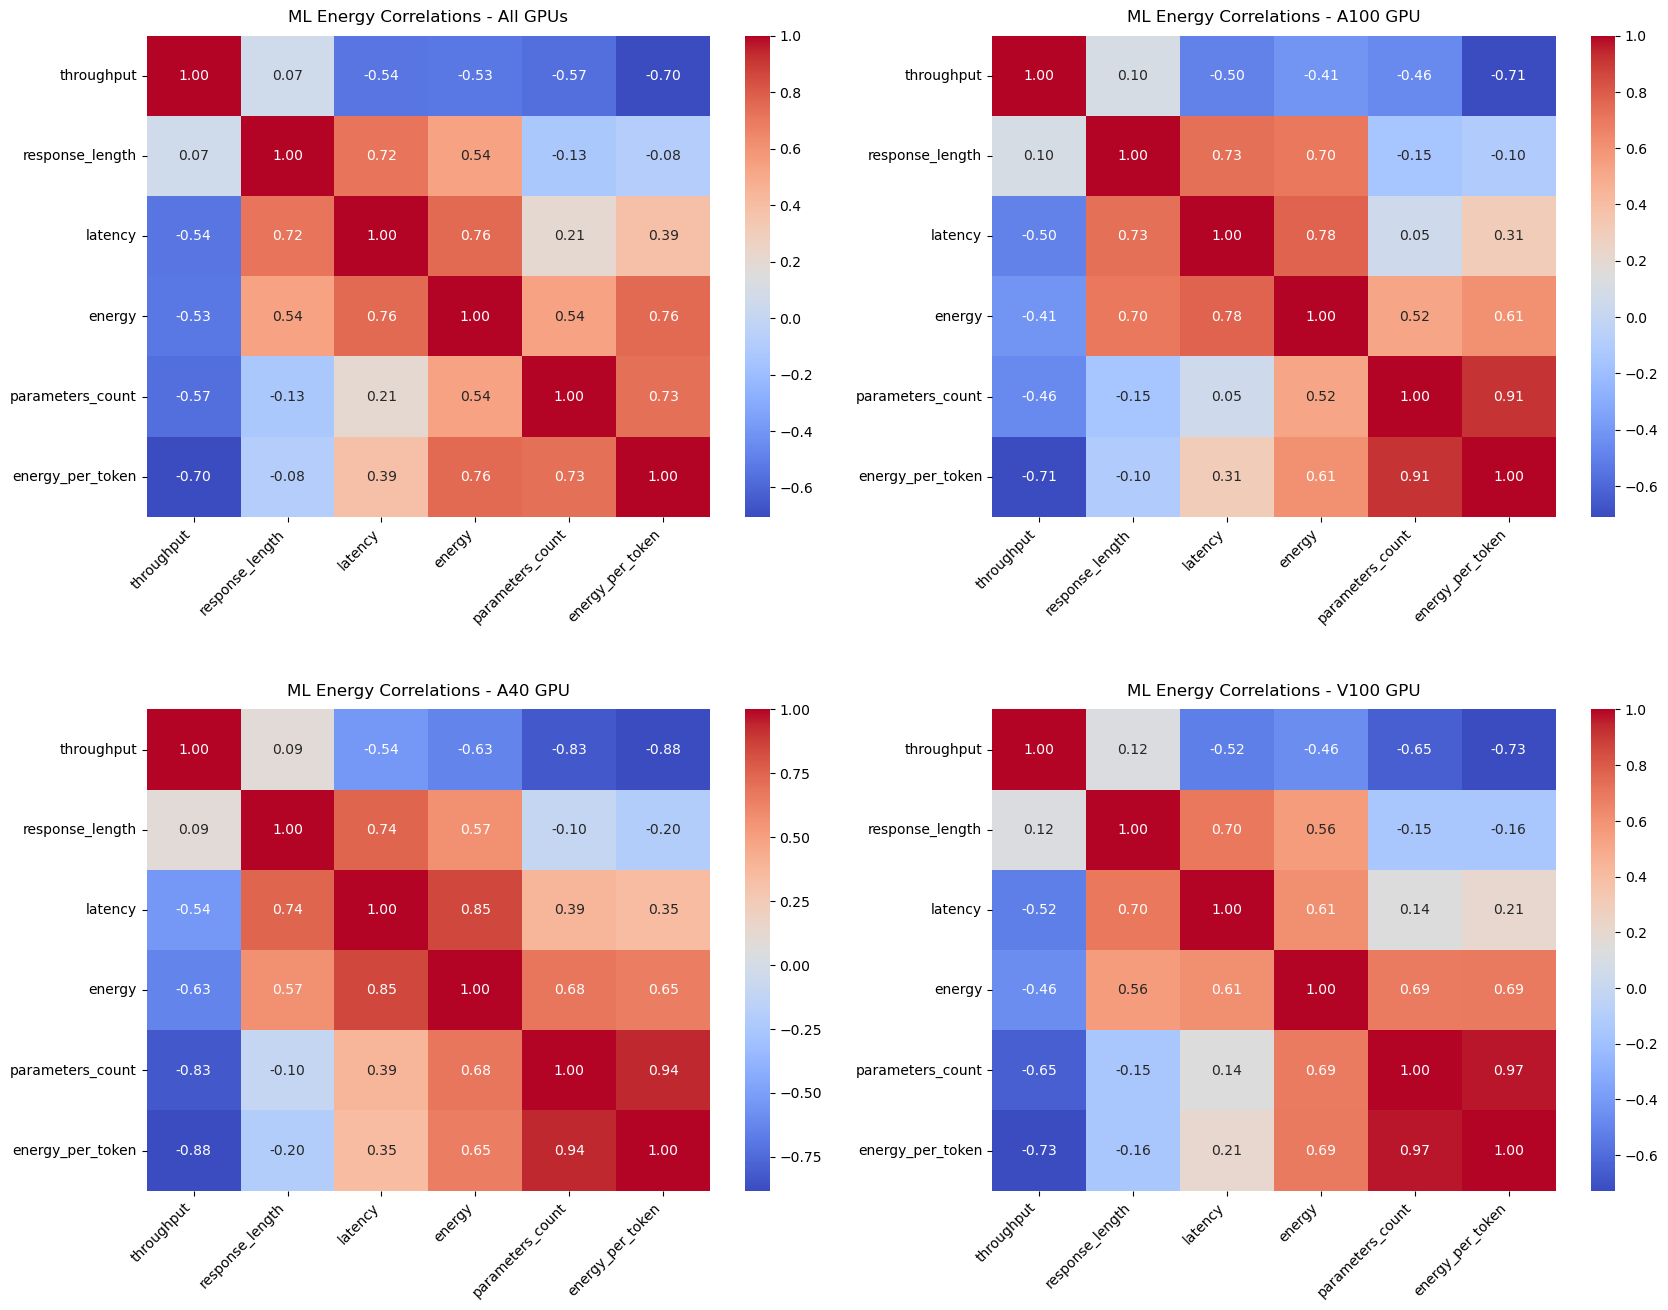

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

plt.subplot(2, 2, 1)

sns.heatmap(
    ml_energy_df[num_feat].corr(), 
    annot=True, 
    cmap='coolwarm',
    fmt='.2f'
)

ax.flat[0].set_title('ML Energy Correlations - All GPUs', pad=10.0)

plt.xticks(rotation=45, ha='right')

for i, gpu in enumerate(ml_energy_gpus, 2):
    
    plt.subplot(2, 2, i)
    
    sns.heatmap(
    ml_energy_df.loc[ml_energy_df['gpu'] == gpu, num_feat].corr(), 
    annot=True, 
    cmap='coolwarm',
    fmt='.2f'
)
    
    ax.flat[i - 1].set_title(f'ML Energy Correlations - {gpu} GPU', pad=10.0)

    plt.xticks(rotation=45, ha='right')

plt.subplots_adjust(hspace=0.4);

Sans surprise, le nombre de paramètres est fortement corrélé à la conso par token. On note aussi une corrélation fortement négative avec le throughput.

# Linear regressions

In [31]:
fig = go.Figure()

ml_energy_clrs = np.array(['blue', 'violet', 'darkgreen'])

ml_energy_gpu_clrs = list(zip(ml_energy_gpus, ml_energy_clrs))

for gpu_col in ml_energy_gpu_clrs:
    plot_scatter(df=ml_energy_df, gpu=gpu_col[0], color=gpu_col[1]) 

    
plot_regression(df=ml_energy_df) 

for gpu_col in ml_energy_gpu_clrs:
    plot_regression(df=ml_energy_df,  gpu=gpu_col[0], color=gpu_col[1]) 

fig.update_layout(
    title='Energy/tokens per model parameters count (<i>data from ml.energy</i>)',
    xaxis=dict(title='#B Parameters'),
    yaxis=dict(title='Energy/tokens [Wh]'),
    template='plotly',
    width=700,
)

fig.show()

Coefs for all GPUs: [0.         0.00022262]
Coefs for A100: [0.         0.00013892]
Coefs for A40: [0.         0.00030805]
Coefs for V100: [0.         0.00020505]


On note que l'A40 est le GPU qui consomme le plus, celui-ci étant moins adapté aux LLM. L'A100 est le plus efficace, étant un GPU plus récent que le V100.

# Throughput study

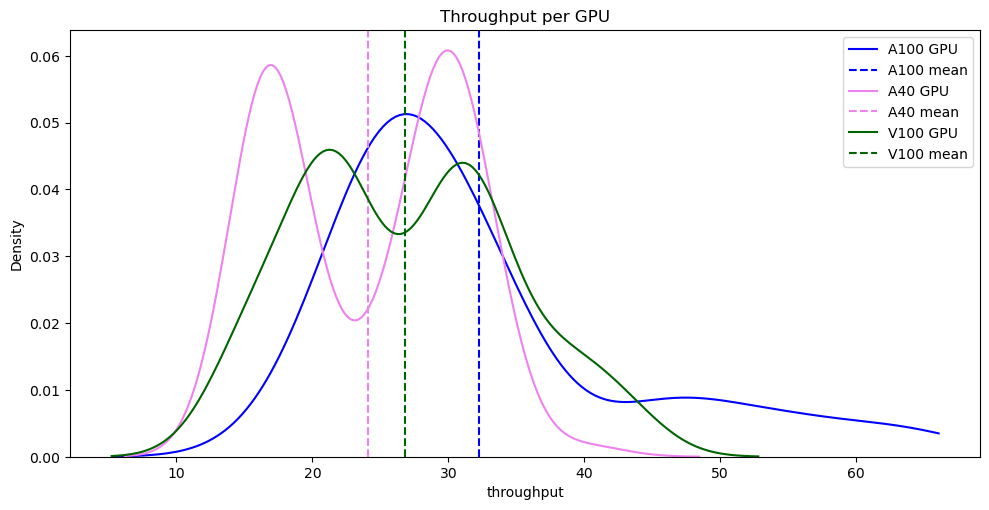

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, gpu in enumerate(ml_energy_gpus):
    
    color = ml_energy_clrs[i]

    gpu_df = ml_energy_df[ml_energy_df['gpu'] == gpu]    
    
    sns.kdeplot(gpu_df, x='throughput', ax=ax, color=color,
                clip=(0, max(ml_energy_df['throughput'])), label=f"{gpu} GPU")

    throughput_mean = gpu_df['throughput'].mean()

    plt.axvline(x=throughput_mean, linestyle="--", color=color, label=f'{gpu} mean')

plt.tight_layout()

plt.legend()

ax.set_title("Throughput per GPU")

plt.plot();

Après avoir observé la distribution des throughputs par carte graphique, on note que l'A40 a un throughput plus lent que l'A100 et la V100. On note aussi que les distributions de l'A40 et de la V100 sont bi-modales alors que la distribution de l'A100 est plus normale.

# LLM Perf dataset inspection

In [15]:
llm_perf_df = pd.read_csv('./data/aggregated_llm_perf.csv')

In [16]:
llm_perf_df.head()

,model,parameters_count,gpu,energy_per_token,throughput,latency,experiment_name
0,EleutherAI/gpt-neox-20b,20.0,NVIDIA A100-SXM4-80GB,0.00327,27.4,9.34,pytorch+cuda+float16+gptq-4bit+exllama-v1
1,EleutherAI/pythia-6.9b-deduped,6.9,NVIDIA A100-SXM4-80GB,0.00179,42.3,6.05,pytorch+cuda+float16+gptq-4bit+exllama-v1
2,EleutherAI/pythia-6.7b,6.7,NVIDIA A100-SXM4-80GB,0.00183,39.9,6.41,pytorch+cuda+float16+gptq-4bit+exllama-v1
3,EleutherAI/pythia-1.4b-deduped,1.4,NVIDIA A100-SXM4-80GB,0.00121,54.8,4.67,pytorch+cuda+float16+gptq-4bit+exllama-v1
4,EleutherAI/gpt-j-6b,6.0,NVIDIA A100-SXM4-80GB,0.00230,30.8,8.31,pytorch+cuda+float16+gptq-4bit+exllama-v1


In [17]:
llm_perf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             1692 non-null   object 
 1   parameters_count  1692 non-null   float64
 2   gpu               1692 non-null   object 
 3   energy_per_token  1692 non-null   float64
 4   throughput        1692 non-null   float64
 5   latency           1692 non-null   float64
 6   experiment_name   1692 non-null   object 
dtypes: float64(4), object(3)
memory usage: 92.7+ KB


In [18]:
llm_perf_df.describe()

,parameters_count,energy_per_token,throughput,latency
count,1692.000000,1692.000000,1692.000000,1692.000000
mean,6.614750,0.002608,66.138895,8.826118
std,9.893855,0.002597,74.397570,8.982957
min,0.001000,0.000062,3.380000,0.394000
25%,0.460000,0.000982,25.100000,3.547500
50%,4.000000,0.001950,40.100000,6.390000
75%,7.000000,0.003242,72.150000,10.200000
max,70.000000,0.022200,650.000000,75.700000


In [19]:
llm_perf_gpus = llm_perf_df['gpu'].unique()

In [20]:
llm_perf_gpus

array(['NVIDIA A100-SXM4-80GB', 'NVIDIA GeForce RTX 4090'], dtype=object)

Il existe 2 types de GPUs dans ce dataset, l'A100 et la RTX 4090. Comme dit auparavant l'A100 est basée sur l'architecture Ampère, alors que  la RTX 4090 est basé sur l'architecture Ada Lovelace plus récente. Ceci étant dit l'A100 est une version serveur, alors que la RTX 4090 est une version desktop avec des capcités plus limitées.

# Correlation study

In [35]:
num_feat = [col for col in llm_perf_df if llm_perf_df.dtypes[col] != 'object']

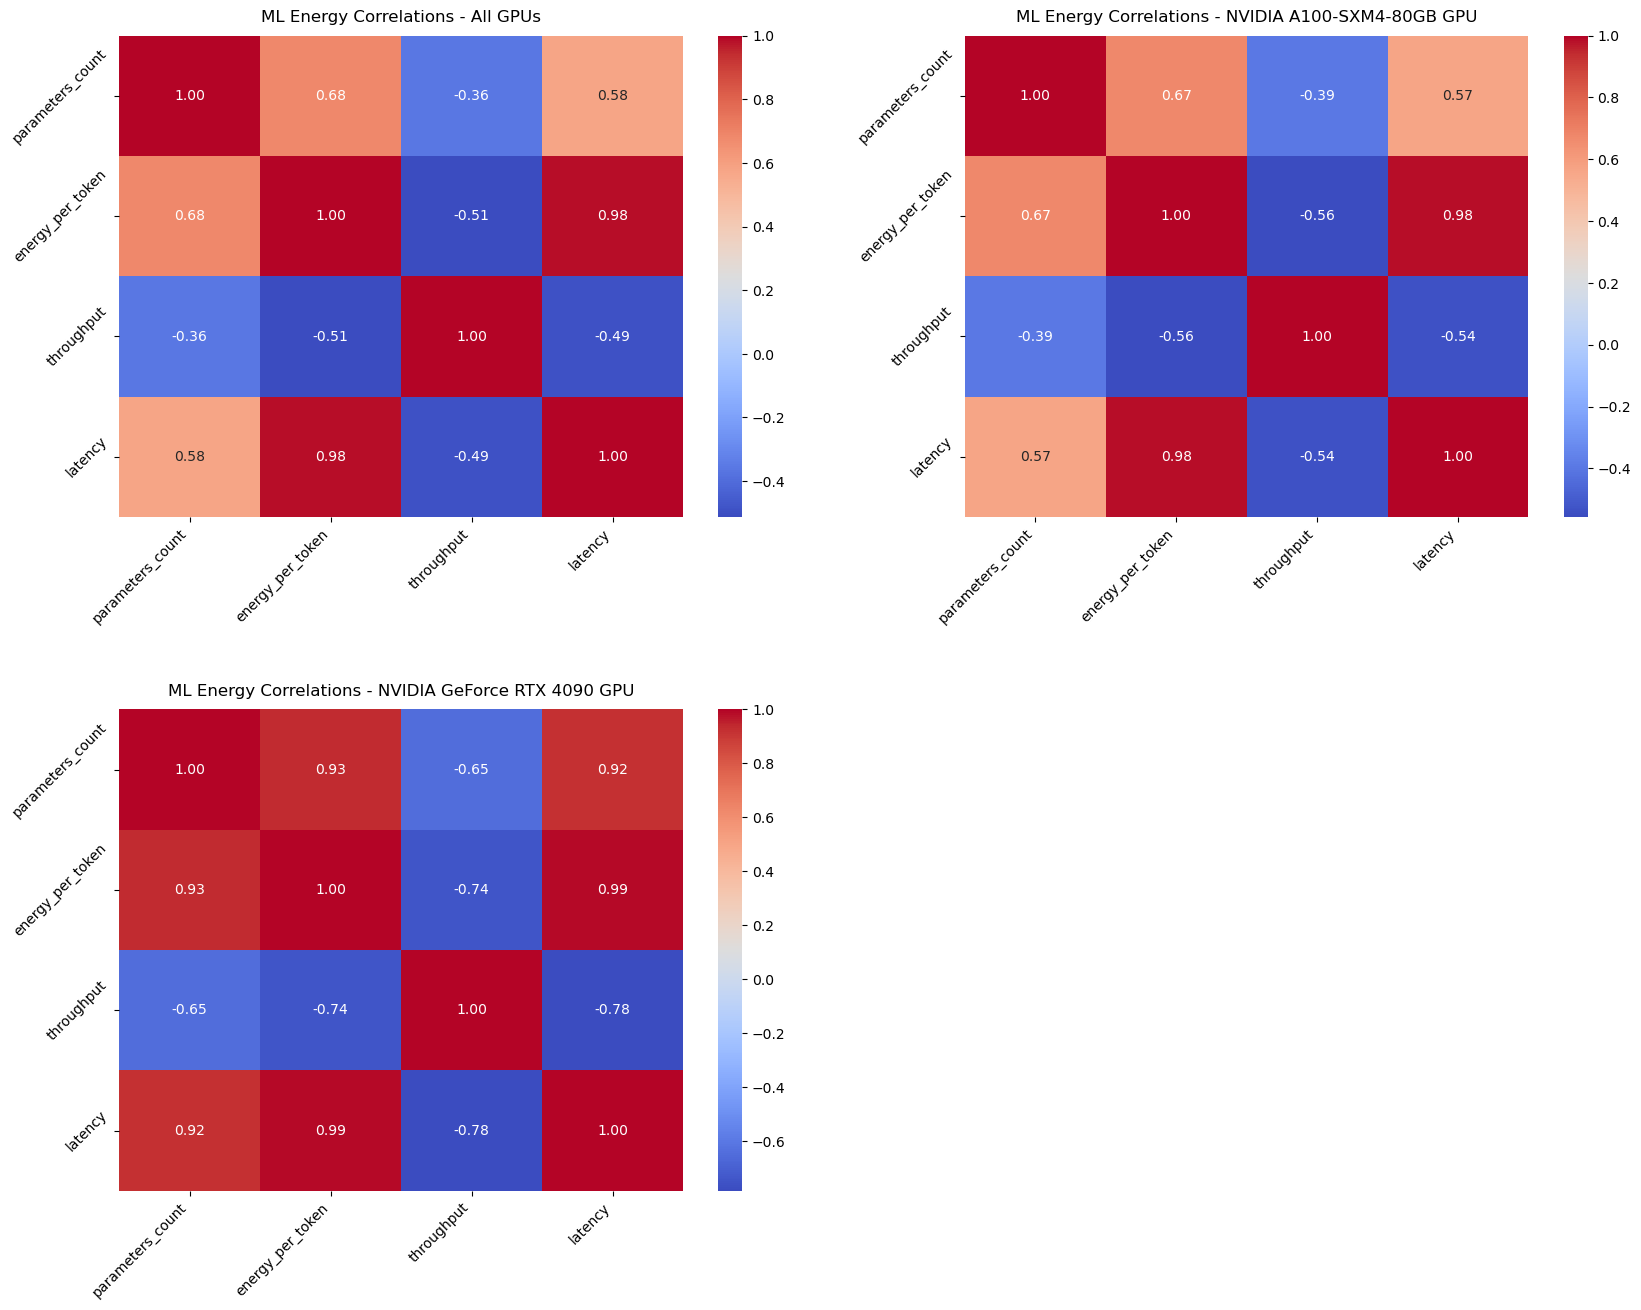

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

plt.subplot(2, 2, 1)

sns.heatmap(
    llm_perf_df[num_feat].corr(), 
    annot=True, 
    cmap='coolwarm',
    fmt='.2f'
)

ax.flat[0].set_title('ML Energy Correlations - All GPUs', pad=10.0)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

for i, gpu in enumerate(llm_perf_gpus, 2):
    
    plt.subplot(2, 2, i)
    
    sns.heatmap(
    llm_perf_df.loc[llm_perf_df['gpu'] == gpu, num_feat].corr(), 
    annot=True, 
    cmap='coolwarm',
    fmt='.2f'
)
    
    ax.flat[i - 1].set_title(f'ML Energy Correlations - {gpu} GPU', pad=10.0)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')

plt.subplots_adjust(hspace=0.4)

fig.delaxes(ax.flatten()[i]);

Dans ce dataset , la latence est beaucoup plus corrélée avec la conso. Le throughput a une corrélation négative également.

# Linear regressions

In [33]:
fig = go.Figure(layout=dict(width=300, height=500))

llm_perf_clrs = np.array(['blue', 'darkorange'])

llm_perf_gpu_clrs = list(zip(llm_perf_gpus, llm_perf_clrs))

for gpu_col in llm_perf_gpu_clrs:
    plot_scatter(df=llm_perf_df, gpu=gpu_col[0], color=gpu_col[1]) 

plot_regression(df=llm_perf_df) 

for gpu_col in llm_perf_gpu_clrs:
    plot_regression(df=llm_perf_df,  gpu=gpu_col[0], color=gpu_col[1]) 

fig.update_layout(
    title='Energy/tokens per model parameters count (<i>data from llm-perf</i>)',
    xaxis=dict(title='#B Parameters'),
    yaxis=dict(title='Energy/tokens [Wh]'),
    template='plotly',
    width=700,
    legend=dict(orientation='h', y=-0.2)
)

fig.show()

Coefs for all GPUs: [0.         0.00017883]
Coefs for NVIDIA A100-SXM4-80GB: [0.         0.00017399]
Coefs for NVIDIA GeForce RTX 4090: [0.         0.00019879]


On note que la RTX 4090 consomme un peu moins mais se retrouve vite limitée en termes de capacités.

# Combined analysis

In [22]:
global_df = pd.concat([ml_energy_df, llm_perf_df])
global_df = global_df[['model', 'gpu', 'parameters_count', 'energy_per_token', 'throughput', 'latency']]

In [23]:
#Trim A100 name to facilitate analysis
global_df['gpu'].replace(["NVIDIA A100-SXM4-80GB", "NVIDIA GeForce RTX 4090"], ["A100", "RTX 4090"], inplace=True)

In [24]:
global_gpus = global_df['gpu'].unique()
global_gpus

array(['A100', 'A40', 'V100', 'RTX 4090'], dtype=object)

# Correlation study

In [35]:
num_feat = [col for col in global_df if global_df.dtypes[col] != 'object']

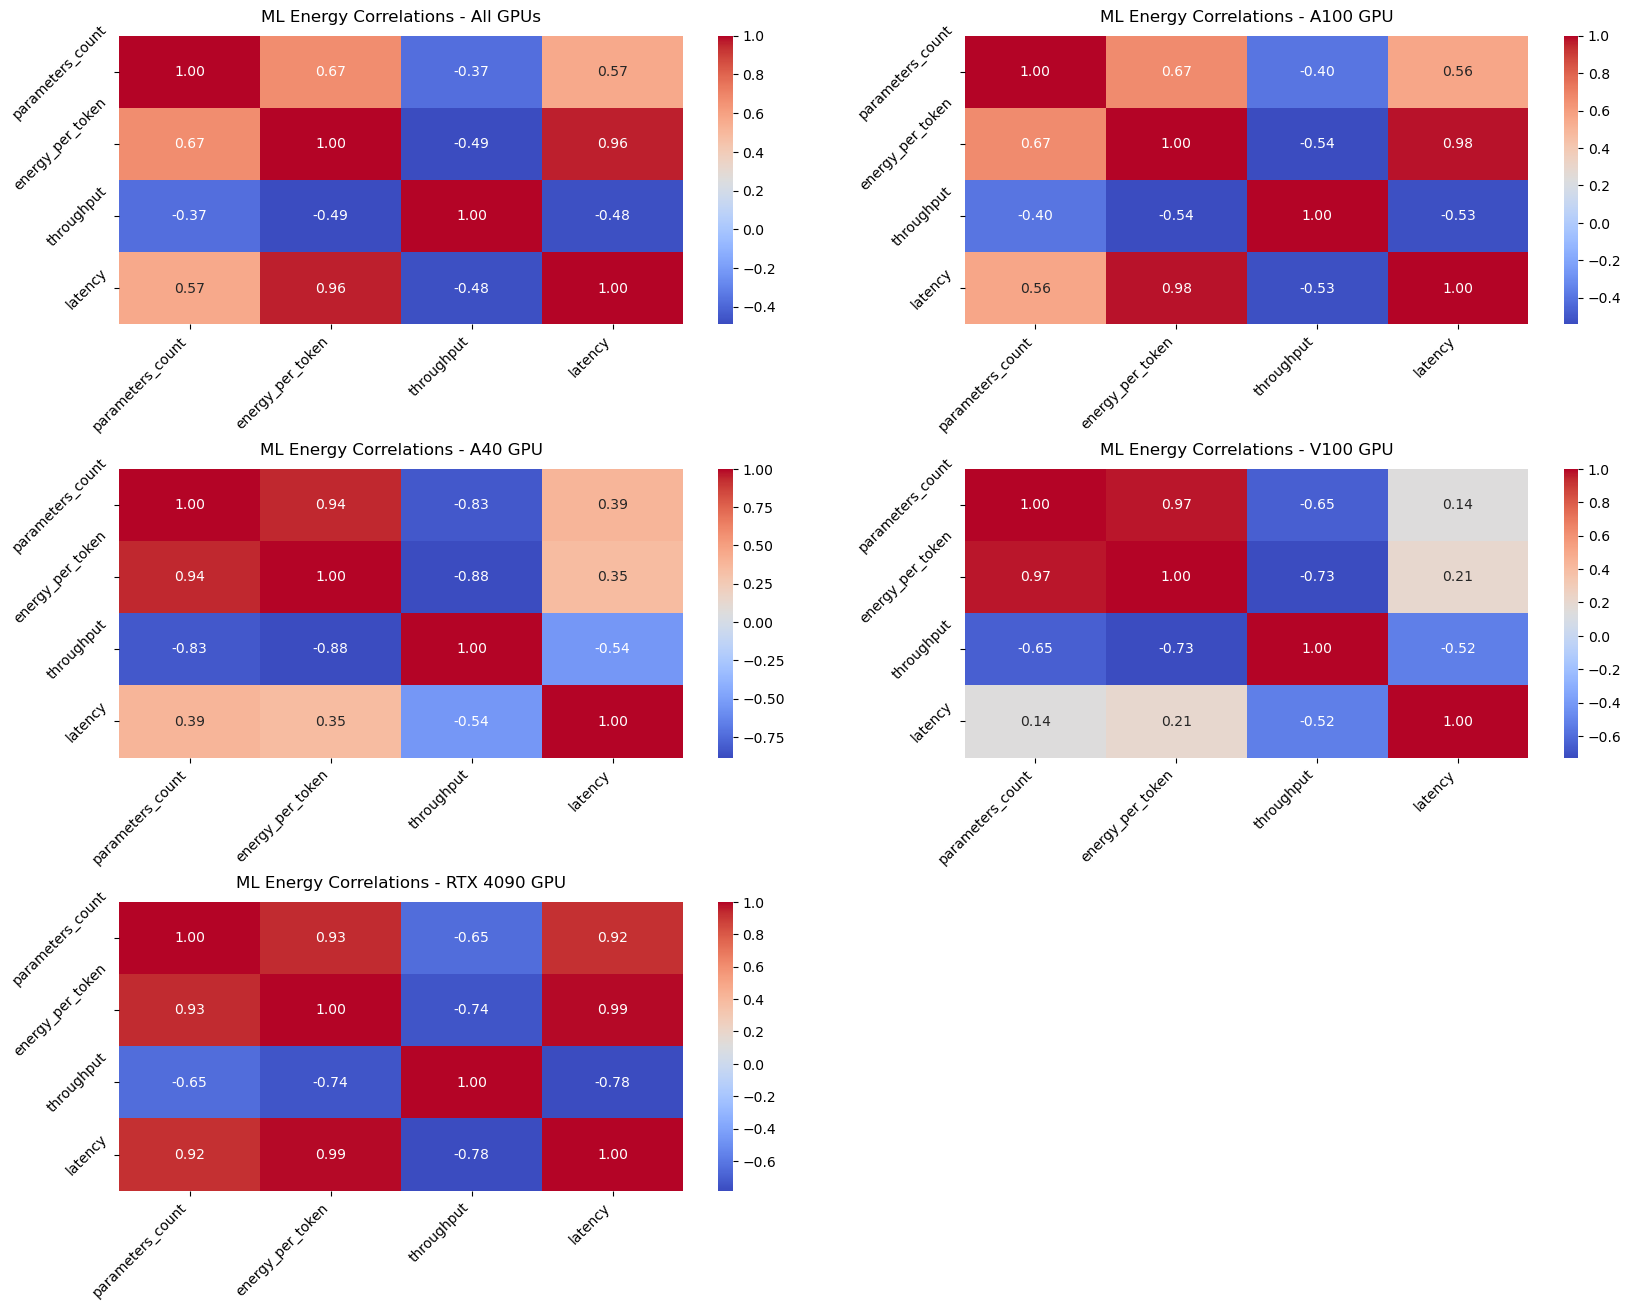

In [43]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

plt.subplot(3, 2, 1)

sns.heatmap(
    global_df[num_feat].corr(), 
    annot=True, 
    cmap='coolwarm',
    fmt='.2f'
)

ax.flat[0].set_title('ML Energy Correlations - All GPUs', pad=10.0)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

for i, gpu in enumerate(global_gpus, 2):
    
    plt.subplot(3, 2, i)
    
    sns.heatmap(
    global_df.loc[global_df['gpu'] == gpu, num_feat].corr(), 
    annot=True, 
    cmap='coolwarm',
    fmt='.2f'
)
    
    ax.flat[i - 1].set_title(f'ML Energy Correlations - {gpu} GPU', pad=10.0)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')

plt.subplots_adjust(hspace=0.5)

fig.delaxes(ax.flatten()[i]);

En analyse combinée, la latence reste importante. L'importance des paramètres dépend du GPU, la latence est la plus importante pour l'A100. Pour l'A40 et le V100, ce sont le nombre de paramètres et le throughput. Pour la RTX, la latence, le throughput et le nombre de paramètres sont importants.

# Linear regressions

In [34]:
fig = go.Figure(layout=dict(width=500, height=500))

global_clrs = np.array(['blue', 'violet', 'darkgreen', 'darkorange'])

global_gpu_clrs = list(zip(global_gpus, global_clrs))

for gpu_col in global_gpu_clrs:
    plot_scatter(df=global_df, gpu=gpu_col[0], color=gpu_col[1]) 

    
plot_regression(df=global_df) 

for gpu_col in global_gpu_clrs:
    plot_regression(df=global_df,  gpu=gpu_col[0], color=gpu_col[1]) 

fig.update_layout(
    title='Energy/tokens per model parameters count (<i>data from ml.energy</i>)',
    xaxis=dict(title='#B Parameters'),
    yaxis=dict(title='Energy/tokens [Wh]'),
    template='plotly',
    width=700,
)

fig.show()

Coefs for all GPUs: [0.         0.00017677]
Coefs for A100: [0.        0.0001724]
Coefs for A40: [0.         0.00030805]
Coefs for V100: [0.         0.00020505]
Coefs for RTX 4090: [0.         0.00019879]


On constate que la V100 et la RTX 4090 sont les plus efficaces pour des modèles à moins de 15B de paramètres. Pareil pour l'A40 qui est plus efficace que l'A100 pour ce type de modèle, mais passée cette limite seule l'A100 permet de faire tourner ces modèles.